In [1]:
import sys
sys.path.append('../../../citation-style-classifier')

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import Levenshtein
import pandas as pd
import seaborn as sns
import re
import time

from config import STYLES
from dataset import read_ref_strings_data, generate_unknown
from evaluation import evaluate_cv
from features import get_features, select_features_chi2
from random import randint, seed
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from statistics import mean
from train import clean

  from numpy.core.umath_tests import inner1d


In [2]:
data_dir = 'data/'
img_dir = 'images/'

In [3]:
dataset = read_ref_strings_data(data_dir + 'dataset/')
print('Dataset size: {}'.format(dataset.shape[0]))
dataset.head()

Dataset size: 85000


doi                style  \
0  10.1016/s0002-9394(14)70125-4  acm-sig-proceedings   
1   10.1016/0920-9964(95)95073-i  acm-sig-proceedings   
2          10.1075/cilt.97.22vek  acm-sig-proceedings   
3   10.1080/19761597.2013.810947  acm-sig-proceedings   
4   10.1016/0378-1119(79)90090-8  acm-sig-proceedings   

                                              string  
0  [1]LEE, S.-H. and TSENG, S.C.G. 1997. Amniotic...  
1  [1]Scheffer, R. et al. 1995. History of premor...  
2  [1]Vekerdi, J. 1993. 4. Word formation in Gips...  
3  [1]Kang, J. et al. 2013. Determinants of succe...  
4  [1]Wickens, M.P. et al. 1979. Restriction map ...

In [4]:
seed(12)
examples = dataset.groupby('style').nth(randint(0, 4999)).reset_index()
print('\n\n'.join(['{}\n{}'.format(s, t) for s, t in zip(examples['style'].tolist(), examples['string'].tolist())]))

acm-sig-proceedings
[1]Fung, E.H.K. and Chan, J.C.K. 2000. ARX Modelling and Compensation of Roundness Errors in Taper Turning. The International Journal of Advanced Manufacturing Technology. 16, 6 (May 2000), 404–412.

american-chemical-society
(1) Fung, E. H. K.; Chan, J. C. K. The International Journal of Advanced Manufacturing Technology 2000, 16, 404–412.

american-chemical-society-with-titles
(1) Fung, E. H. K.; Chan, J. C. K. ARX Modelling and Compensation of Roundness Errors in Taper Turning. The International Journal of Advanced Manufacturing Technology 2000, 16, 404–412.

american-institute-of-physics
1 E.H.K. Fung and J.C.K. Chan, The International Journal of Advanced Manufacturing Technology 16, 404 (2000).

american-sociological-association
Fung, E. H. K., and J. C. K. Chan. 2000. “ARX Modelling and Compensation of Roundness Errors in Taper Turning.” The International Journal of Advanced Manufacturing Technology 16(6):404–12. Retrieved

apa
Fung, E. H. K., & Chan, J. C. K.

In [5]:
dataset = clean(dataset, random_state=0)
print('Dataset size: {}'.format(dataset.shape[0]))

Dataset size: 82834


In [6]:
dataset_unknown = generate_unknown(dataset, 5000, random_state=0)
dataset = pd.concat([dataset, dataset_unknown])
print('Dataset size: {}'.format(dataset.shape[0]))

Dataset size: 87834


In [7]:
train_doi, test_doi = train_test_split(dataset['doi'].drop_duplicates(), random_state=0)
train_dataset = dataset.loc[dataset['doi'].isin(train_doi)]
test_dataset = dataset.loc[dataset['doi'].isin(test_doi)]
print('Train dataset size: {}'.format(train_dataset.shape[0]))
print('Test dataset size: {}'.format(test_dataset.shape[0]))

Train dataset size: 65723
Test dataset size: 22111


In [8]:
algo_results = []
for name, algo in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(random_state=0)),
                   ('Linear SVC', LinearSVC(random_state=0)),
                   ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0))]:
    accuracies, _ = evaluate_cv(train_dataset, algo, feature_fun=get_features, feature_selector=select_features_chi2,
                                nfeatures=5000, ngrams=(2, 4))
    algo_results.extend([(name, fold, accuracy) for fold, accuracy in enumerate(accuracies)])
    print('Accuracy for {} algorithm {}'.format(name, mean(accuracies)))

Accuracy for Naive Bayes algorithm 0.9103134389822651
Accuracy for Logistic Regression algorithm 0.9417018147701165
Accuracy for Linear SVC algorithm 0.8983351179660207
Accuracy for Random Forest algorithm 0.8341546445990069


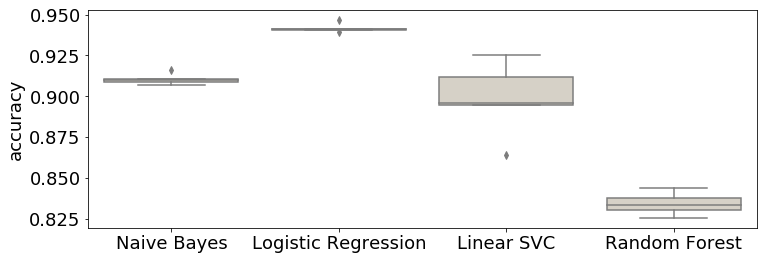

In [9]:
cv_df = pd.DataFrame(algo_results, columns=['model', 'fold', 'accuracy'])
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 4))
ax = sns.boxplot(x='model', y='accuracy', data=cv_df, color="#d8d2c4")
ax.set_xlabel('')
plt.savefig(img_dir + 'algos.png', dpi=300, bbox_inches='tight')

In [10]:
count_vectorizer, tfidf_transformer, train_features = get_features(train_dataset['string'], nfeatures=5000,
                                                                   feature_selector=select_features_chi2,
                                                                   ngrams=(2, 4))
_, _, test_features = get_features(test_dataset['string'], count_vectorizer=count_vectorizer,
                                   tfidf_transformer=tfidf_transformer)
model = LogisticRegression(random_state=0).fit(train_features, train_dataset['style'])
prediction = model.predict(test_features)
print('The final accuracy: {}'.format(accuracy_score(test_dataset['style'], prediction)))

The final accuracy: 0.941838903713084


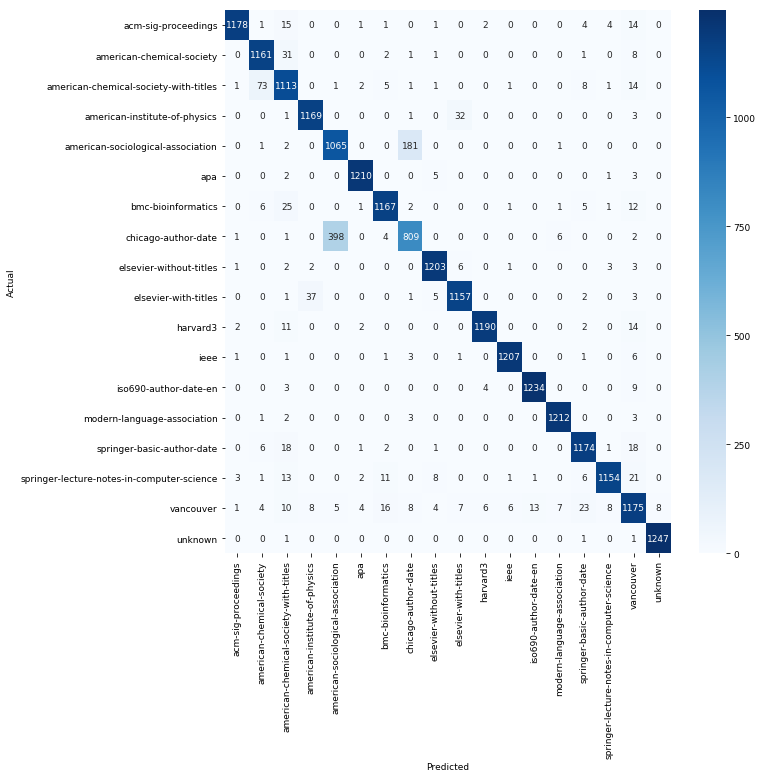

In [11]:
matrix = confusion_matrix(test_dataset['style'], prediction)
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(figsize=(10,10))
cm = sns.heatmap(matrix, annot=True, fmt='d', xticklabels=STYLES+['unknown'], yticklabels=STYLES+['unknown'],
                 cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(img_dir + 'cm.png', dpi=300, bbox_inches='tight')

In [12]:
start = time.time()
dataset = read_ref_strings_data(data_dir + 'dataset/')
dataset = clean(dataset, random_state=0)
dataset_unknown = generate_unknown(dataset, 5000, random_state=0)
dataset = pd.concat([dataset, dataset_unknown])
count_vectorizer, tfidf_transformer, train_features = get_features(dataset['string'], nfeatures=5000,
                                                                   feature_selector=select_features_chi2,
                                                                   ngrams=(2, 4))
m = LogisticRegression(random_state=0).fit(train_features, dataset['style'])
end = time.time()
print(end - start)

84.3456199169159


In [13]:
start = time.time()
with open(data_dir + 'time/sample_strings_raw_100.txt') as f:
    test_strings = f.readlines()
test_strings = [s.strip() for s in test_strings]
_, _, test_features = get_features(test_strings, count_vectorizer=count_vectorizer,
                                   tfidf_transformer=tfidf_transformer)
prediction = m.predict(test_features)
end = time.time()
print(end - start)

0.032358407974243164


In [14]:
def clean(s):
    for r in ['^\(1\)', '^\[1\]', '^1\.', '^1(?!\d)', '\.$']:
        s = re.sub(r, '', s.strip())
    return s.strip().lower()

with open(data_dir + 'test_strings_raw.txt') as f:
    test_strings = f.readlines()
test_strings = [clean(s) for s in test_strings]

with open(data_dir + 'test_styles.txt') as f:
    test_styles = f.readlines()
test_styles = [s.strip() for s in test_styles]

print("Test dataset size: {}".format(len(test_strings)))

Test dataset size: 22111


In [15]:
def read_generated_strings(parser):
    dataset = []
    for style in STYLES:
        with open(data_dir + 'strings/' + parser + '/strings_' + style, 'r') as file:
            data = [clean(re.sub('^\d+ ', '', d.strip())) for d in file.readlines()]
        dataset.append(data)
    return dataset

dataset_cermine = read_generated_strings('cermine')

In [16]:
def lev_scores(dataset):
    return [[Levenshtein.distance(a,b) for a,b in zip(test_strings, d)] for d in dataset]
scores_cermine = lev_scores(dataset_cermine)

In [17]:
def predict(scores):
    prediction = []
    min_scores = []
    for i in range(len(scores[0])):
        scores_i = [s[i] for s in scores]
        score_min = min(scores_i)
        style = STYLES[scores_i.index(score_min)]
        prediction.append(style)
        min_scores.append(score_min)
    return prediction, min_scores

prediction_cermine, scores = predict(scores_cermine)

In [18]:
print(accuracy_score(test_styles, prediction_cermine))

0.5480077789335625


In [19]:
start = time.time()
with open(data_dir + 'test_strings_raw.txt') as f:
    test_strings = f.readlines()
test_strings = [clean(s) for s in test_strings]

with open(data_dir + 'test_styles.txt') as f:
    test_styles = f.readlines()
test_styles = [s.strip() for s in test_styles]

dataset_cermine = read_generated_strings('cermine')
scores_cermine = lev_scores(dataset_cermine)
prediction_cermine, scores = predict(scores_cermine)
end = time.time()

print(accuracy_score(test_styles, prediction_cermine))
print(end-start)

0.5480077789335625
18.645047187805176
